In [1]:
# imports
import math
import numpy as np
import pandas as pd
from scipy import stats
import random
import matplotlib.pyplot as plt
# import mayavi.mlab as mlab
import seaborn as sns

import sys
import json
import shutil

In [2]:
def load_parameters(filepath):
    '''
    Loads input and output directories
    '''
    with open(filepath) as fp:
        parameter = json.load(fp)

    return parameter

sys.path.insert(0, '../src')

In [3]:
# Seating_chart_builder

n = 28
seats = {str(i): 0 for i in range(n)}
seats_28 = seats.copy()
for key, val in seats.items():    
    if int(key)%4 == 0:
        x = int(7/2 * int(key) + 2)
        y = 3
            
    elif int(key)%4 == 1:
        x = int(7/2 * (int(key) - 1) + 2)
        y = 16
        
    elif int(key)%4 == 2:
        x = int(7/2 * int(key) + 2)
        y = 8
        
    else:
        x = int(7/2 * (int(key) - 1) + 2)
        y = 21
    seats_28[key] = [x, y]
    
n_ = 56
seats_ = {str(i): 0 for i in range(n_)}
seats_56 = seats_.copy()
for key, val in seats_.items():
    if int(key)%4 == 0:
        x = int(7 * int(key)/4 + 2)
        y = 3
            
    elif int(key)%4 == 1:
        x = int(7 * (int(key) - 1)/4 + 2)
        y = 16
        
    elif int(key)%4 == 2:
        x = int(7 * int(key)/4 -1)
        y = 8
        
    else:
        x = int(7 * (int(key) - 1)/4 -1)
        y = 21
    seats_56[key] = [x, y]
# ----------------------------------------------------------
f_seats = {str(i): [] for i in range(n)}
f_seats_28 = f_seats.copy()
for key, val in seats.items(): 
    if int(key)%4 == 0:
        x = math.floor(int(key)/2)  + math.floor(int(key)/6) + 1
        y = 1
            
    elif int(key)%4 == 1:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 4
        
    elif int(key)%4 == 2:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 2
        
    else:
        x = math.floor(int(key)/2) + math.floor(int(key)/6) + 1
        y = 5
    f_seats_28[key] = [x, y]
    
f_seats_ = {str(i): [] for i in range(n_)}
f_seats_56 = f_seats_.copy()
for key, val in f_seats_56.items():
    if int(key)%4 == 0:
        x = math.floor(int(key)/4)  + math.floor(int(key)/12) + 1
        y = 1
            
    elif int(key)%4 == 1:
        x = math.floor(int(key) - 1)/4  + math.floor((int(key) - 1)/12) + 1
        y = 4
        
    elif int(key)%4 == 2:
        x = math.floor(int(key)/4)  + math.floor(int(key)/12) + 1
        y = 2
        
    else:
        x = math.floor((int(key) -1)/4)  + math.floor((int(key) - 1)/12) + 1
        y = 5
    f_seats_56[key] = [int(x), int(y)]

In [4]:

for i in range(28):
    out = math.floor(i/2) + math.floor(i/6) + 1
    print(i, out)

0 1
1 1
2 2
3 2
4 3
5 3
6 5
7 5
8 6
9 6
10 7
11 7
12 9
13 9
14 10
15 10
16 11
17 11
18 13
19 13
20 14
21 14
22 15
23 15
24 17
25 17
26 18
27 18


In [5]:
# LOCAL IMPORT
# import data from other files
from bus import bus_sim, trip_stats
from classroom import func
from infection import generate_infectivity_curves, plot_infectivity_curves, return_aerosol_transmission_rate



# import functions from other files

# import default parameters
# bus_params = load_parameters('../config/bus_params.json')

# class_params = load_parameters('../config/class_params.json')

In [6]:
# INFECTION

# plot % infectivity based on day- lognormal w/ % chance of infectivity

# proxy_vars = generate_infectivity_curves()
# plot_infectivity_curves(proxy_vars)

In [7]:
############ initialize variables

# setup default infection parameters
floor_area = 86.02  # ft2 # 11.4 m * 2.3 m * (m^2->ft^2) = 86.02 ~= 86 ft^2
mean_ceiling_height = 12  # ft # 1.85 m -> ft = 6.06 ~= 6 ft
air_exchange_rate = 20  # /hr (air changes per hour (ACH)) #moving bus mph average


##Assumed Parameter Identified as 0.2 for Classrooms, 1.0 for outdoors#
# and .5 for buses with windows open
primary_outdoor_air_fraction = 0.5  # 1.0 = natural ventilation
aerosol_filtration_eff = 0  # >0.9997 HEPA, =0.2-0.9 MERVs, =0 no filter

#Average daily RH for San Diego is 69%
relative_humidity = 0.69 
physical_params = [floor_area, mean_ceiling_height, air_exchange_rate, primary_outdoor_air_fraction,
                        aerosol_filtration_eff, relative_humidity]

# Physiological Parameters
breathing_flow_rate = 0.5  # m3/hr
max_aerosol_radius = 2  # micrometers
physio_params = [breathing_flow_rate, max_aerosol_radius]

# Disease Parameters
exhaled_air_inf = 30  # infection quanta/m3, changes with acitivity type.
max_viral_deact_rate = 0.3  # /hr
disease_params = [exhaled_air_inf, max_viral_deact_rate]

# Precautionary Parameters
mask_passage_prob = .1 # 1 = no masks, ~0.1 cloth, <0.05 N95
risk_tolerance = 0.1  # expected transmissions per infector
prec_params = [mask_passage_prob, risk_tolerance]
############

In [8]:
def get_neighbor_incoming(x, y, old):
    neighb = []
    count = 0
    # flower petal arrow assumption:
    # if arrow = directly towards, 50% of quanta will go from neighbor -> selected
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            count += 1
            try:
                direction = bus_flow_direction[x + i][y + j]
                magnitude = bus_flow_velocity[x + i][y + j]
                value = old[x + i][y + j]
                this_val = old[x][y]
                this_mag = bus_flow_velocity[x][y]

                idx = direction_dict[count].index(direction)
                this_val += (risk_dict[idx] * (magnitude + .1) * value)
                new_val = this_val * magnitude_dict[this_mag]
                neighb.append(new_val)
            except:
                neighb.append(0)
    return neighb

def air_effects(i, j, oldQ):
    '''
    i, j: x y locations

    oldQ: old quanta at that cube

    get neighbors directions and magnitude
    determine % in and % out
    '''
    # windows
    if j < 2 or j > 4:
        new = oldQ * .85

    # ceiling vents
    if (i > 6 and i < 9) or (i > 12 and i < 15):
        new = oldQ * .6
    else:
        new = 1.1 * oldQ
    return new

def make_new_heat(old, bus_pos, init_infected_ = None):
    '''
    1 minute step used to calculate concentration_distribution iteratively
    '''
    if init_infected_:
        pass
    else:
        init_infected_ = np.random.choice(list(bus_pos.keys()))

    ############## GET CORRECT FLOW POSITIONS *******

    initial_loc = bus_pos[init_infected_]
    new = old.copy()
    out = old.copy()
    for i in range(len(old)):
        for j in range(len(old[i])):
            dist = math.sqrt(((initial_loc[0] - i)**2) + (initial_loc[1] - j)**2)
            new_val = old[i][j] + (1/(2.02 ** dist))
            new[i][j] = new_val

            ##################################################
    for i in range(len(old)):
        for j in range(len(old[i])):
            neighbor_val = np.mean(get_neighbor_incoming(i, j, new))
            air_val = air_effects(i, j, neighbor_val)
            out[i][j] = air_val
    return out, init_infected_

bus_flow_direction = np.array([[1, 1, 1, 2, 3, 4, 4],
              [1, 4, 7, 8, 9, 9, 6],
              [4, 7, 7, 8, 9, 9, 6],
              [4, 4, 5, 2, 5, 4, 4],
              [8, 5, 5, 2, 5, 5, 8], #
              [1, 1, 1, 2, 5, 6, 6],
              [1, 1, 2, 2, 5, 6, 6],
              [1, 1, 2, 2, 3, 3, 6],
              [5, 5, 5, 2, 5, 5, 5],
              [1, 1, 1, 2, 3, 3, 3], #
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 5, 5, 2, 2, 3, 3], #
              [1, 1, 1, 2, 2, 3, 3],
              [1, 1, 1, 2, 2, 3, 3],
              [1, 1, 1, 2, 3, 6, 6],
              [1, 1, 2, 2, 3, 3, 6],
              [1, 2, 2, 2, 3, 3, 6], #
              [4, 4, 4, 5, 6, 6, 6],
              [2, 2, 2, 5, 5, 5, 5],
              [2, 2, 5, 8, 2, 2, 2]])

def concentration_distribution(num_steps, num_sims, bus_flow_pos):
    '''
    Simulate distribution of concentration after
    30 steps
    100 runs
    random initial student/infectivity


    '''
    nothings = np.zeros(bus_flow_direction.shape)
    temp, initial = make_new_heat(nothings, bus_flow_pos, init_infected_=None)
    temp_array = []

    for step in range(num_steps):
        temp, initial = make_new_heat(temp, bus_flow_pos, init_infected_=None)
        print(temp)
        temp_array.append(temp)
    print(len(temp_array))
    return temp_array[-1]



In [9]:
# BUS

# --> Airavata: implement ############# section ########## with user input instead of loop

# initialize: parameter loops

windows = ['up', 'down']
num_students = [28, 56]
masks = [1, .9, .8]
num_sims = 10
trip_length = 30


# table output: % chance of >= 1 infection over 1 bus trip

out_array = [[], [], []]

for w in range(len(windows)):

    for n in range(len(num_students)):
        
        for m in range(len(masks)):
            # windows up vs down # extrapolated from ACH ratio for open windows on bus
            # and open vs closed windows in a classroom (prior research)
            ##### verify this #####
            if windows[w] == 'up': # effective ACH = 5
                win_effect = 0.25
            if windows[w] == 'down': # effective ACH = 20
                win_effect = 1

            bus_aerosol = return_aerosol_transmission_rate(floor_area, mean_ceiling_height,
                                    air_exchange_rate * win_effect,
                                    aerosol_filtration_eff, relative_humidity, breathing_flow_rate,
                                    exhaled_air_inf, max_viral_deact_rate, mask_passage_prob,
                                    max_aerosol_radius=2, primary_outdoor_air_fraction=0.2)
            
            bus_trip, conc = bus_sim(windows[w], num_students[n], masks[m], num_sims, trip_length, bus_aerosol)
            # this is an array of transmission % for each student on the trip
            
            
            #######################################
            
#             for run in range(100):
                # bus trip 1way
                
                # output: array of % chance of infection
                
                # output: array of distance from initially infected
                
                # output: %infect for neighbors/close/far [<1 m, 1-2m, >2m]
                
            
            # value = averaged % of >=1 infection
            # calculate for each trip
            
            
            # reference array
            out_array[m].append([windows[w],num_students[n],masks[m]]) # append value
        
out_df = pd.DataFrame(out_array)
out_df.columns = ['WinUp_28', 'WinUp56', 'WinDown28', 'WinDown56']
out_df.index = ['100%', '90%', '80%'] # mask wearing rate
out_df

# initialize: scatter

# output: scatterplot of distance from initial (X) vs Likelihood of infection (Y)
# Y: each point = 1 student, averaged over 100 reruns (random initial student, random infectivity)




# initialize: close_neighbors

# 5 students: KDEplot of % likelihood of infection over 1 trip


C:\Users\Bailey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bailey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,WinUp_28,WinUp56,WinDown28,WinDown56
100%,"[up, 28, 1]","[up, 56, 1]","[down, 28, 1]","[down, 56, 1]"
90%,"[up, 28, 0.9]","[up, 56, 0.9]","[down, 28, 0.9]","[down, 56, 0.9]"
80%,"[up, 28, 0.8]","[up, 56, 0.8]","[down, 28, 0.8]","[down, 56, 0.8]"


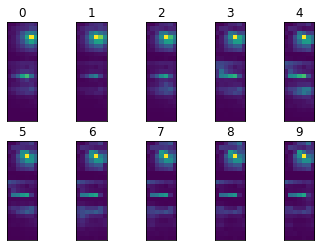

In [45]:
fig, axs = plt.subplots((math.floor(len(conc) / 5)), (math.floor(len(conc) / 2)), edgecolor='k')

axs = axs.ravel()
for c in range(len(conc)):
    axs[c].matshow(conc[c])
    axs[c].tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
    axs[c].set_title(c)

In [ ]:
# CLASS

# initialize: parameter loops

masks = [100, 90, 80]
windows = ['up', 'down']
num_students = [10, 25, 40]

# table output: % chance of >= 1 infection over 1 day

# initialize: KDEplot of % likelihood of transmission for each student (100 reruns)



In [ ]:
# AIR FLOW

# Well-mixed room assumption

# ACH discussion

# Class

# Heatmap of relative concentration @ mouth level over 1 hour (100 runs, random initially infected/infective)

# Bus

# Heatmap of concentration & relative concentration over 1 trip (30 mins) (100 runs, random init inf/infective)

# plot quanta / time in bus: front/mid/back????

In [ ]:
# needed plots

# demo for distance:

# plot: max initial infectivity, mean, min @ 0m 1m 2m

# plot: bus: infection % 1 trip / semester in worst case (1 infectious / day)
    # red: masks 90 windows up
    # orange: masks 100 windows up 
    # green: masks 90 windows down
    # blue: masks 100 windows down
    

# plot: class: infection % 1 day / semester in worst case (1 infectious)
    # red: windows closed, no vents: ACH = 
    # orange: windows closed, ventilation: ACH = 
    # green: windows open, no vents: ACH = 
    # blue: windows open, vents: ACH = 
    
# tables for >= 1 infection